In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from glicko2 import Player

In [2]:
# Setup 
np.random.seed(42)

# Number of arms
n = 100

# Number of matches between the optimal arm and suboptimal arms
m = 10

# Assume Normal Noise 
delta = 0.1
sigma = .25
mu = [0.5] + [0.5-delta]*(n-1)

# Initialize Players
players = {}
for i in range(n):
    players[i] = Player()

In [3]:
# --- Data Collection for the Rating Period ---
# This structure will hold, for each player, lists of:
# - ratings of opponents they played against
# - RDs of opponents they played against
# - outcomes of those games (1 for win, 0 for loss for the player in question)
# All ratings/RDs are taken *before* any updates in this period.

period_games_data = {player_id: {'opponent_ratings': [], 'opponent_rds': [], 'outcomes': []} for player_id in range(n)}
raw_match_log = [] # Optional: to store raw [p1, p2, winner] for debugging or other analysis

# Simulate Matches and Collect Data
for i in range(1, n):  # Optimal arm (0) plays against each suboptimal arm (i)
    for _ in range(m): # m matches between arm 0 and arm i
        # Get current ratings and RDs of players involved (these are their "pre-period" stats for this batch of games)
        rating_player_0 = players[0].getRating()
        rd_player_0 = players[0].getRd()
        rating_player_i = players[i].getRating()
        rd_player_i = players[i].getRd()

        # Simulate one game outcome
        performance_player_0 = np.random.normal(mu[0], sigma)
        performance_player_i = np.random.normal(mu[i], sigma)

        if performance_player_0 > performance_player_i: # Player 0 wins
            winner_id = 0
            # Data for Player 0
            period_games_data[0]['opponent_ratings'].append(rating_player_i)
            period_games_data[0]['opponent_rds'].append(rd_player_i)
            period_games_data[0]['outcomes'].append(1) # Player 0 won

            # Data for Player i
            period_games_data[i]['opponent_ratings'].append(rating_player_0)
            period_games_data[i]['opponent_rds'].append(rd_player_0)
            period_games_data[i]['outcomes'].append(0) # Player i lost
        else: # Player i wins
            winner_id = i
            # Data for Player 0
            period_games_data[0]['opponent_ratings'].append(rating_player_i)
            period_games_data[0]['opponent_rds'].append(rd_player_i)
            period_games_data[0]['outcomes'].append(0) # Player 0 lost

            # Data for Player i
            period_games_data[i]['opponent_ratings'].append(rating_player_0)
            period_games_data[i]['opponent_rds'].append(rd_player_0)
            period_games_data[i]['outcomes'].append(1) # Player i won
        
        raw_match_log.append([0, i, winner_id])

In [4]:
# --- Update Ratings for All Players After the Period ---
for player_id in range(n):
    if period_games_data[player_id]['opponent_ratings']: # Check if the player played any games
        players[player_id].update_player(
            period_games_data[player_id]['opponent_ratings'],
            period_games_data[player_id]['opponent_rds'],
            period_games_data[player_id]['outcomes']
        )


In [5]:
# Extract Glicko-2 scores, RDs, and volatilities
ratings = []
rds = []
vols = []

for i in range(n):
    ratings.append(players[i].getRating())
    rds.append(players[i].getRd())
    vols.append(players[i].vol)

# Create a Pandas DataFrame for easier viewing
results_df = pd.DataFrame({
    'PlayerID': list(range(n)),
    'Rating': ratings,
    'RD': rds,
    'Volatility': vols
})

print("Glicko-2 Results (Processed as a single period):")
print(results_df.sort_values('Rating', ascending=False))

Glicko-2 Results (Processed as a single period):
    PlayerID       Rating          RD  Volatility
83        83  1670.266069  148.674206    0.060009
20        20  1670.266069  148.674206    0.060009
60        60  1670.266069  148.674206    0.060009
61        61  1670.266069  148.674206    0.060009
0          0  1604.673348   16.485595    0.107821
..       ...          ...         ...         ...
55        55  1159.467731  148.674235    0.060081
57        57  1159.467731  148.674235    0.060081
70        70  1159.467731  148.674235    0.060081
77        77  1159.467731  148.674235    0.060081
16        16  1159.467731  148.674235    0.060081

[100 rows x 4 columns]


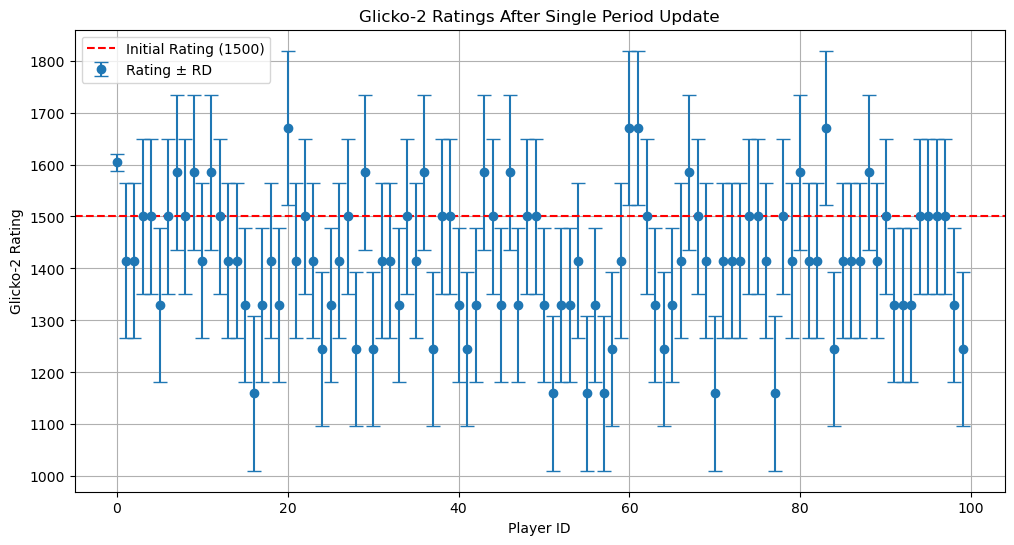

In [6]:
# Plotting the ratings
plt.figure(figsize=(12, 6))
plt.errorbar(results_df['PlayerID'], results_df['Rating'], yerr=results_df['RD'], fmt='o', capsize=5, label='Rating ± RD')
plt.axhline(y=1500, color='r', linestyle='--', label='Initial Rating (1500)')
plt.xlabel("Player ID")
plt.ylabel("Glicko-2 Rating")
plt.title("Glicko-2 Ratings After Single Period Update")
plt.legend()
plt.grid(True)
plt.show()




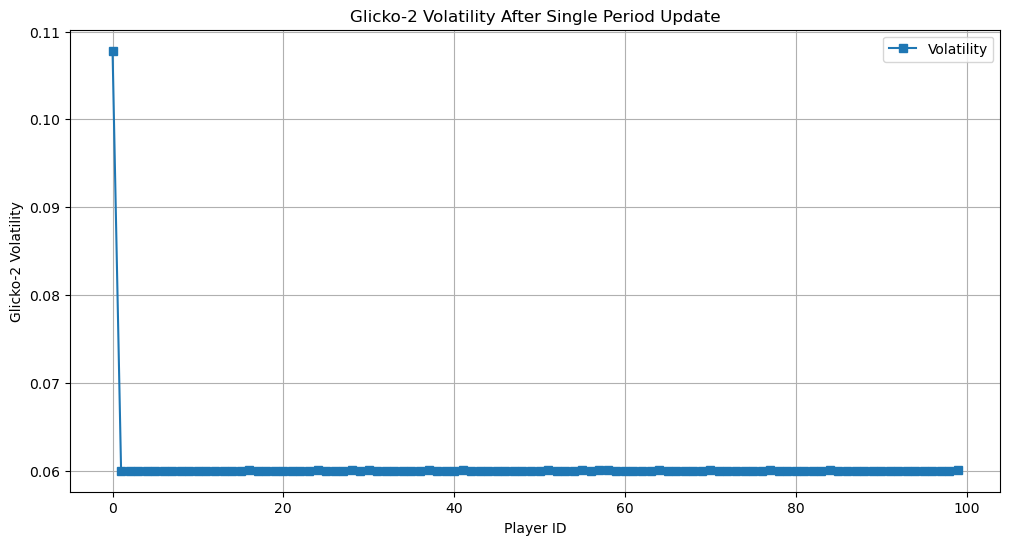

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(results_df['PlayerID'], results_df['Volatility'], 's-', label='Volatility')
plt.xlabel("Player ID")
plt.ylabel("Glicko-2 Volatility")
plt.title("Glicko-2 Volatility After Single Period Update")
plt.legend()
plt.grid(True)
plt.show()


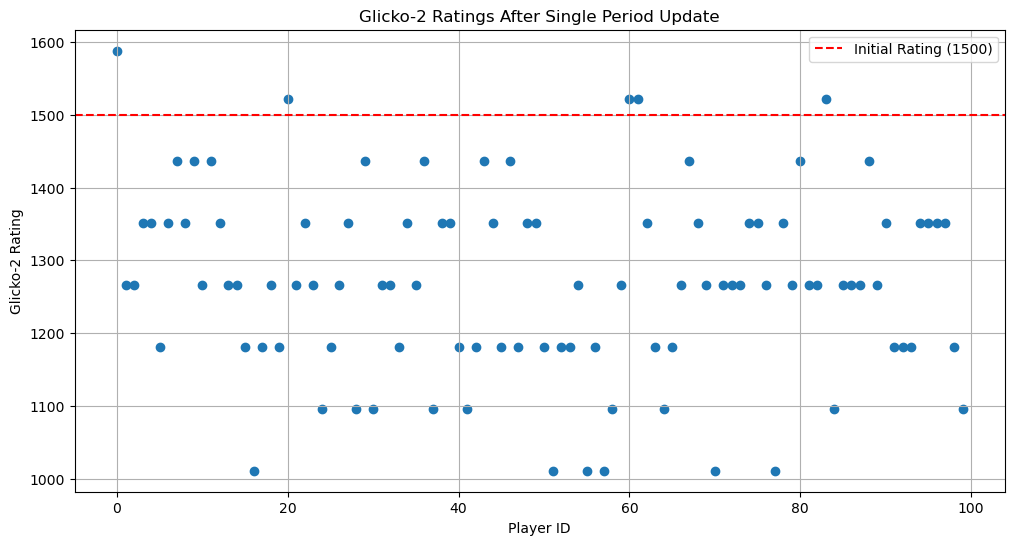

In [8]:
# Plotting the ratings
plt.figure(figsize=(12, 6))
plt.scatter(results_df['PlayerID'], results_df['Rating']-results_df['RD'])
plt.axhline(y=1500, color='r', linestyle='--', label='Initial Rating (1500)')
plt.xlabel("Player ID")
plt.ylabel("Glicko-2 Rating")
plt.title("Glicko-2 Ratings After Single Period Update")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# For reference, you can also see the distribution of wins/losses
# from raw_match_log if needed.
# print(f"\nTotal matches simulated: {len(raw_match_log)}")
# wins_for_player_0 = sum(1 for match in raw_match_log if match[2] == 0)
# print(f"Wins for Player 0 (Optimal Arm): {wins_for_player_0} out of {len(raw_match_log) - m*(n-1) + (n-1)*m}") # Should be (n-1)*m total games
# print(f"Total games played by Player 0: {len(period_games_data[0]['outcomes'])}")
# for i in range(1, n):
#    print(f"Total games played by Player {i}: {len(period_games_data[i]['outcomes'])}")


In [10]:
# Train a Reward Model Using the Standard Method

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set seed for reproducibility
torch.manual_seed(42)

# Define the Reward Model Network using Player IDs
class RewardModel(nn.Module):
    def __init__(self, num_players, embedding_dim=1, hidden_size=n):
        super(RewardModel, self).__init__()
        # Embedding layer to learn a vector representation for each player ID
        self.embedding = nn.Embedding(num_players, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_size) # Input to fc1 is the embedding dimension
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, 1) # Output is a single reward score
    def forward(self, player_ids):
        # player_ids is a tensor of player IDs (long integers)
        embedded_players = self.embedding(player_ids)
        x = self.fc1(embedded_players)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize the model
# 'n' is the number of players/arms, defined in a previous cell (e.g., n=100)
embedding_dimension = 1 # You can tune this hyperparameter
reward_net = RewardModel(num_players=n, embedding_dim=embedding_dimension)
print("Reward Model Network (ID-based input):")
print(reward_net)

Reward Model Network (ID-based input):
RewardModel(
  (embedding): Embedding(100, 1)
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


In [14]:
# --- Prepare Data for Reward Model Training (ID-based) ---
chosen_ids_list = []
rejected_ids_list = []

# raw_match_log contains [player1_id, player2_id, winner_id]
for match in raw_match_log:
    player1_id = match[0]
    player2_id = match[1]
    winner_id = match[2]

    # Ensure IDs are integers, as they will be used as indices for embeddings
    p1_id = int(player1_id)
    p2_id = int(player2_id)
    win_id = int(winner_id)


    if win_id == p1_id:
        chosen_ids_list.append(p1_id)
        rejected_ids_list.append(p2_id)
    elif win_id == p2_id:
        chosen_ids_list.append(p2_id)
        rejected_ids_list.append(p1_id)
    else:
        # This case should ideally not happen if winner is always one of p1 or p2
        # print(f"Skipping match with unexpected winner: {match}")
        continue

# Convert lists to PyTorch tensors. IDs should be LongTensor for nn.Embedding
chosen_ids_tensor = torch.tensor(chosen_ids_list, dtype=torch.long)
rejected_ids_tensor = torch.tensor(rejected_ids_list, dtype=torch.long)

print(f"Number of training pairs: {len(chosen_ids_tensor)}")
print(f"Shape of chosen_ids_tensor: {chosen_ids_tensor.shape}") # Should be [num_matches]
print(f"Shape of rejected_ids_tensor: {rejected_ids_tensor.shape}") # Should be [num_matches]

# Create a TensorDataset and DataLoader for batching
dataset = TensorDataset(chosen_ids_tensor, rejected_ids_tensor)
# Batch size can be tuned. Using 64 as an example.
dataloader = DataLoader(dataset, batch_size=max(1, len(dataset) // 10) if len(dataset) > 10 else len(dataset) , shuffle=True) # Ensure batch_size is at least 1
if not chosen_ids_list:
    print("Warning: No training data was prepared. Check raw_match_log and its processing.")
else:
    print(f"Using batch size: {dataloader.batch_size}")

Number of training pairs: 990
Shape of chosen_ids_tensor: torch.Size([990])
Shape of rejected_ids_tensor: torch.Size([990])
Using batch size: 99


In [15]:
# --- Train the Reward Model (ID-based) ---
# Loss function and optimizer
optimizer = optim.Adam(reward_net.parameters(), lr=0.001) # Learning rate can be tuned
num_epochs = 1000  # Number of training epochs, adjust as needed
print_every_epochs = 100
print("\nStarting Reward Model Training (ID-based)...")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    for chosen_batch_ids, rejected_batch_ids in dataloader:
        optimizer.zero_grad()

        # Get rewards for the chosen and rejected player IDs in the batch
        rewards_chosen = reward_net(chosen_batch_ids)
        rewards_rejected = reward_net(rejected_batch_ids)

        # Pairwise preference loss: -log(sigmoid(reward_chosen - reward_rejected))
        loss = -torch.nn.functional.logsigmoid(rewards_chosen - rewards_rejected).mean()

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches +=1

    if num_batches > 0:
        avg_epoch_loss = epoch_loss / num_batches
        if (epoch + 1) % print_every_epochs == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
    elif (epoch + 1) % print_every_epochs == 0 : # Handle case where dataloader was empty after all
         print(f"Epoch [{epoch+1}/{num_epochs}], No data processed in this epoch.")


print("Reward Model Training Finished.")


Starting Reward Model Training (ID-based)...
Epoch [100/1000], Loss: 0.6440
Epoch [200/1000], Loss: 0.6318
Epoch [300/1000], Loss: 0.6295
Epoch [400/1000], Loss: 0.6304
Epoch [500/1000], Loss: 0.6278
Epoch [600/1000], Loss: 0.6285
Epoch [700/1000], Loss: 0.6282
Epoch [800/1000], Loss: 0.6283
Epoch [900/1000], Loss: 0.6285
Epoch [1000/1000], Loss: 0.6274
Reward Model Training Finished.


In [16]:
# Example: Score all players using their IDs
# Create a tensor of all player IDs (0 to n-1)
all_player_ids_tensor = torch.arange(n, dtype=torch.long)

with torch.no_grad(): # Disable gradient calculation for inference
    all_player_rewards = reward_net(all_player_ids_tensor)

# Create a DataFrame for the new scores
id_scores_df = pd.DataFrame({
    'PlayerID': np.arange(n), # Assumes PlayerIDs are 0 to n-1
    'Reward': all_player_rewards.numpy().flatten()
})

# Merge the new scores with the existing results_df
# Remove the old score column if it exists from a previous run with feature-based model
if 'Reward' in results_df.columns:
    results_df = results_df.drop(columns=['Reward'])
if 'Reward' in results_df.columns: # Remove if re-running this cell
     results_df = results_df.drop(columns=['Reward'])

results_df = pd.merge(results_df, id_scores_df, on='PlayerID', how='left')

print("\nResults DataFrame with ID-based Reward Model Scores:")
print(results_df.sort_values('Reward', ascending=False))


Results DataFrame with ID-based Reward Model Scores:
    PlayerID       Rating          RD  Volatility    Reward
61        61  1670.266069  148.674206    0.060009  0.801973
20        20  1670.266069  148.674206    0.060009  0.574827
83        83  1670.266069  148.674206    0.060009  0.572477
60        60  1670.266069  148.674206    0.060009  0.484593
9          9  1585.133026  148.674199    0.059991  0.370353
..       ...          ...         ...         ...       ...
57        57  1159.467731  148.674235    0.060081 -1.975601
51        51  1159.467731  148.674235    0.060081 -1.976020
70        70  1159.467731  148.674235    0.060081 -2.222967
55        55  1159.467731  148.674235    0.060081 -2.228958
77        77  1159.467731  148.674235    0.060081 -2.230290

[100 rows x 5 columns]


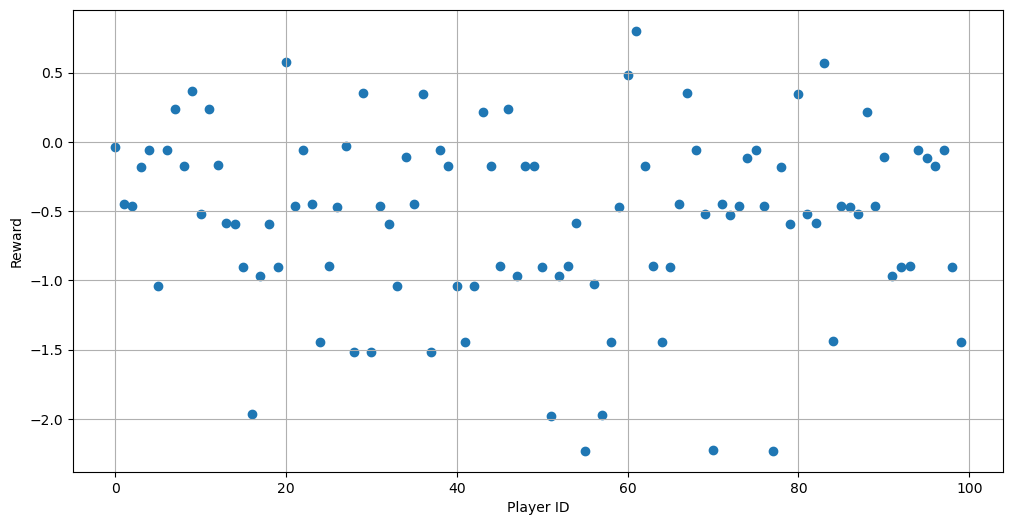

In [17]:
# Plotting the ratings
plt.figure(figsize=(12, 6))
plt.scatter(results_df['PlayerID'], results_df['Reward'])
plt.xlabel("Player ID")
plt.ylabel("Reward")
plt.grid(True)
plt.savefig('reward.png')
plt.show()


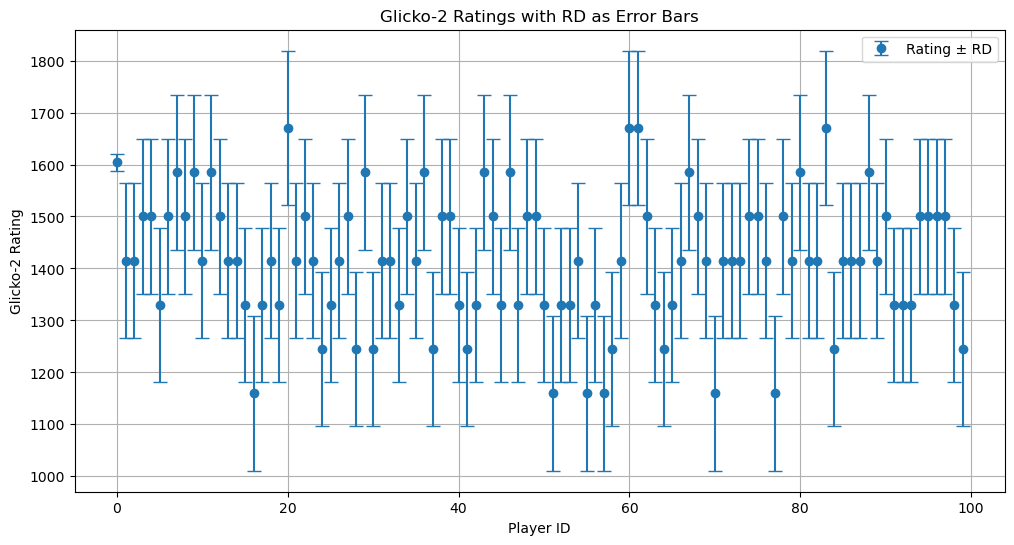

In [18]:
# Plotting the ratings
plt.figure(figsize=(12, 6))
plt.errorbar(results_df['PlayerID'], results_df['Rating'], yerr=results_df['RD'], fmt='o', capsize=5, label='Rating ± RD')
#plt.axhline(y=1500, color='r', linestyle='--', label='Initial Rating (1500)')
plt.xlabel("Player ID")
plt.ylabel("Glicko-2 Rating")
plt.title("Glicko-2 Ratings with RD as Error Bars")
plt.legend()
plt.grid(True)

plt.savefig('glicko_err_bar.png')
plt.show()


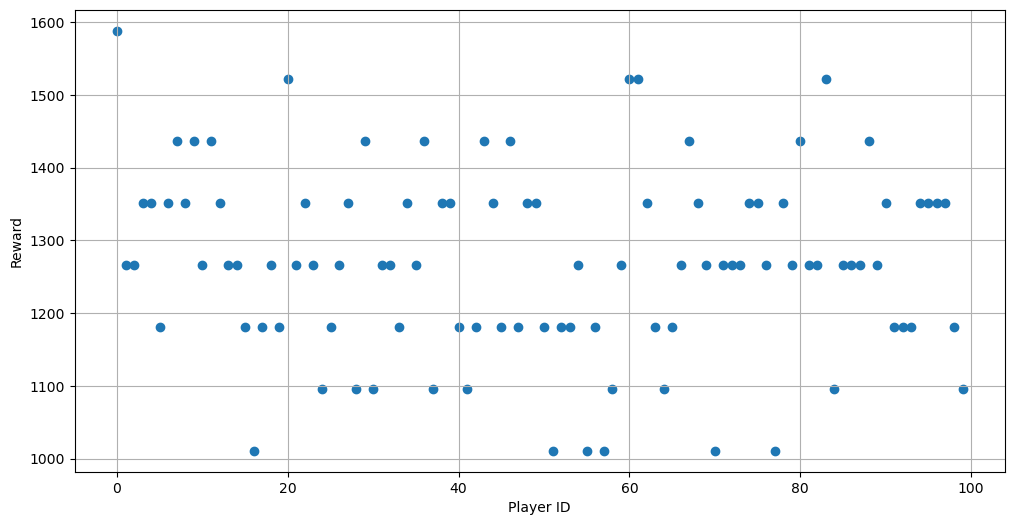

In [19]:
# Plotting the ratings
plt.figure(figsize=(12, 6))
plt.scatter(results_df['PlayerID'], results_df['Rating'] - results_df['RD'])
plt.xlabel("Player ID")
plt.ylabel("Reward")
plt.grid(True)

plt.savefig('glicko_pess.png')
plt.show()

array([1588.18775298, 1266.1927743 , 1266.1927743 , 1351.32580301,
       1351.32580301, 1181.05972455, 1351.32580301, 1436.45882697,
       1351.32580301, 1436.45882697, 1266.1927743 , 1436.45882697,
       1351.32580301, 1266.1927743 , 1266.1927743 , 1181.05972455,
       1010.79349594, 1181.05972455, 1266.1927743 , 1181.05972455,
       1521.59186249, 1266.1927743 , 1351.32580301, 1266.1927743 ,
       1095.92663731, 1181.05972455, 1266.1927743 , 1351.32580301,
       1095.92663731, 1436.45882697, 1095.92663731, 1266.1927743 ,
       1266.1927743 , 1181.05972455, 1351.32580301, 1266.1927743 ,
       1436.45882697, 1095.92663731, 1351.32580301, 1351.32580301,
       1181.05972455, 1095.92663731, 1181.05972455, 1436.45882697,
       1351.32580301, 1181.05972455, 1436.45882697, 1181.05972455,
       1351.32580301, 1351.32580301, 1181.05972455, 1010.79349594,
       1181.05972455, 1181.05972455, 1266.1927743 , 1010.79349594,
       1181.05972455, 1010.79349594, 1095.92663731, 1266.19277

In [49]:
# --- Prepare Data for Regression Training (ID to Rating) ---
# The training data is now the PlayerID and their corresponding Glicko Rating
player_ids = results_df['PlayerID'].values
pess_target = (results_df['Rating']-results_df['RD']).values

# Convert numpy arrays to PyTorch tensors
# IDs should be LongTensor for the embedding layer
# Ratings should be FloatTensor to be used as labels with MSELoss
ids_tensor = torch.tensor(player_ids, dtype=torch.long)
ratings_tensor = torch.tensor(pess_target, dtype=torch.float32).unsqueeze(1)

print(f"Total number of samples: {len(ids_tensor)}")
print(f"Shape of ids_tensor: {ids_tensor.shape}")
print(f"Shape of ratings_tensor: {ratings_tensor.shape}")

# --- Train/Test Split ---
from sklearn.model_selection import train_test_split

# Split the data (80% train, 20% test)
train_ids, test_ids, train_ratings, test_ratings = train_test_split(
    ids_tensor, ratings_tensor, 
    test_size=0.1, 
    random_state=42,  # For reproducibility
    shuffle=True
)

print(f"\nAfter split:")
print(f"Training samples: {len(train_ids)}")
print(f"Test samples: {len(test_ids)}")
print(f"Train ratio: {len(train_ids)/len(ids_tensor):.2%}")
print(f"Test ratio: {len(test_ids)/len(ids_tensor):.2%}")

# Create separate datasets and dataloaders for training and testing
train_dataset = TensorDataset(train_ids, train_ratings)
test_dataset = TensorDataset(test_ids, test_ratings)

# Create dataloaders
batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for test

print(f"\nDataLoader info:")
print(f"Training batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")


Total number of samples: 100
Shape of ids_tensor: torch.Size([100])
Shape of ratings_tensor: torch.Size([100, 1])

After split:
Training samples: 90
Test samples: 10
Train ratio: 90.00%
Test ratio: 10.00%

DataLoader info:
Training batches: 9
Test batches: 1


In [50]:
# --- Train the Network with Mean Squared Error (MSE) Loss ---
# The model 'reward_net' is used as-is from the previous cell definition
pess_net = RewardModel(num_players=n, embedding_dim=embedding_dimension)
print("Reward Model Network (ID-based input):")
print(pess_net)

# Loss function for regression
loss_function = nn.MSELoss()
optimizer = optim.Adam(pess_net.parameters(), lr=0.0005) # A higher learning rate can sometimes work for MSE
num_epochs = 500 # Regression might need more/different epochs
print_every_epochs = 500

print("\nStarting Network Training (ID to Rating Regression)...")

# Lists to store training and test losses for tracking
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # --- Training Phase ---
    pess_net.train()  # Set model to training mode
    epoch_train_loss = 0.0
    num_train_batches = 0
    
    # The dataloader now yields batches of IDs and their corresponding ratings
    for id_batch, rating_batch in train_dataloader:
        optimizer.zero_grad()
        # Get predicted ratings from the network
        predicted_ratings = pess_net(id_batch)
        # Calculate MSE loss between predicted and actual ratings
        loss = loss_function(predicted_ratings, rating_batch)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        num_train_batches += 1
    
    # --- Test Phase ---
    pess_net.eval()  # Set model to evaluation mode
    epoch_test_loss = 0.0
    num_test_batches = 0
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for id_batch, rating_batch in test_dataloader:
            # Get predicted ratings from the network
            predicted_ratings = pess_net(id_batch)
            # Calculate MSE loss between predicted and actual ratings
            loss = loss_function(predicted_ratings, rating_batch)
            
            epoch_test_loss += loss.item()
            num_test_batches += 1
    
    # Calculate average losses
    avg_train_loss = epoch_train_loss / num_train_batches if num_train_batches > 0 else 0
    avg_test_loss = epoch_test_loss / num_test_batches if num_test_batches > 0 else 0
    
    # Store losses for tracking
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    
    # Print progress
    if (epoch + 1) % print_every_epochs == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train MSE: {avg_train_loss:.4f}, Test MSE: {avg_test_loss:.4f}")

print("Network Training Finished.")

# --- Final Test Error Computation ---
pess_net.eval()
final_test_loss = 0.0
num_test_samples = 0

with torch.no_grad():
    for id_batch, rating_batch in test_dataloader:
        predicted_ratings = pess_net(id_batch)
        loss = loss_function(predicted_ratings, rating_batch)
        final_test_loss += loss.item() * len(id_batch)  # Multiply by batch size for proper averaging
        num_test_samples += len(id_batch)

final_test_mse = final_test_loss / num_test_samples
final_test_rmse = torch.sqrt(torch.tensor(final_test_mse))

print(f"\n--- Final Test Performance ---")
print(f"Test MSE: {final_test_mse:.4f}")
print(f"Test RMSE: {final_test_rmse:.4f}")


Reward Model Network (ID-based input):
RewardModel(
  (embedding): Embedding(100, 1)
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)

Starting Network Training (ID to Rating Regression)...
Epoch [500/500], Train MSE: 10814.6141, Test MSE: 28656.6523
Network Training Finished.

--- Final Test Performance ---
Test MSE: 28656.6523
Test RMSE: 169.2828



Results DataFrame with Predicted Glicko Ratings (MSE):
    PlayerID       Rating      pess_nn          RD  Volatility
83        83  1670.266069  1249.960693  148.674206    0.060009
20        20  1670.266069  1303.005249  148.674206    0.060009
60        60  1670.266069  1388.698364  148.674206    0.060009
61        61  1670.266069  1313.232666  148.674206    0.060009
0          0  1604.673348  1274.019531   16.485595    0.107821
..       ...          ...          ...         ...         ...
55        55  1159.467731  1177.639160  148.674235    0.060081
57        57  1159.467731  1178.818115  148.674235    0.060081
70        70  1159.467731  1216.743896  148.674235    0.060081
77        77  1159.467731  1202.462891  148.674235    0.060081
16        16  1159.467731  1251.374268  148.674235    0.060081

[100 rows x 5 columns]


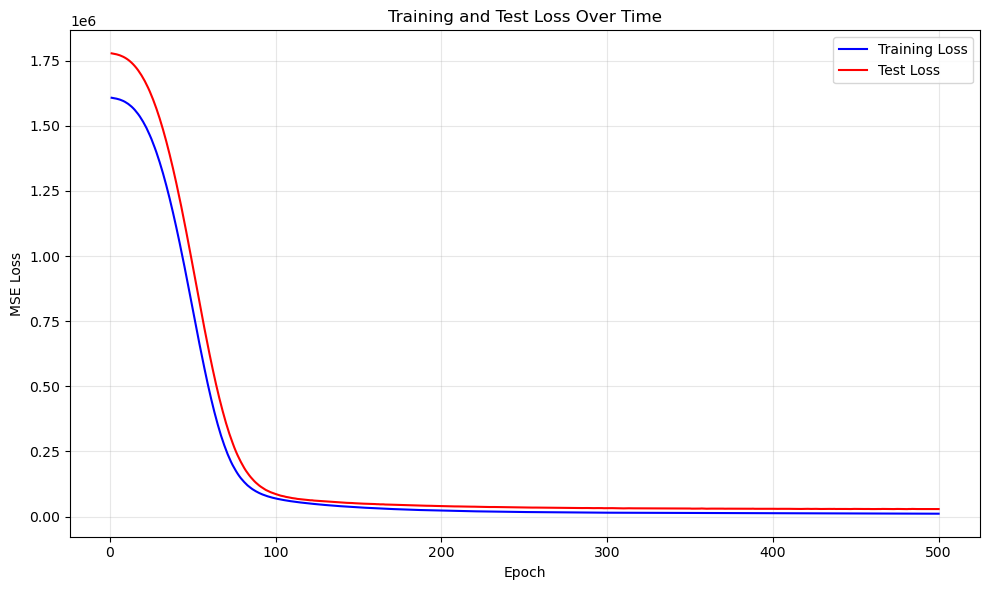


--- Test Set Analysis ---
Test Mean Absolute Error (MAE): 137.3404
Test Mean Absolute Percentage Error (MAPE): 10.10%
Test R² Score: -0.0772


In [51]:

# --- Evaluate the Model by Predicting Ratings for All Players ---
all_player_ids_tensor = torch.arange(n, dtype=torch.long)
with torch.no_grad(): # Disable gradient calculation for inference
    predicted_ratings_all = pess_net(all_player_ids_tensor)

# Add the predicted ratings to the results_df for comparison
# First, remove old prediction columns if they exist from previous runs
for col in ['pess_nn']:
    if col in results_df.columns:
        results_df = results_df.drop(columns=[col])

results_df['pess_nn'] = predicted_ratings_all.numpy().flatten()

print("\nResults DataFrame with Predicted Glicko Ratings (MSE):")
# Display actual and predicted ratings side-by-side, sorted by the actual rating
print(results_df[['PlayerID', 'Rating', 'pess_nn', 'RD', 'Volatility']].sort_values('Rating', ascending=False))

# --- Optional: Plot Training and Test Loss Curves ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Additional Test Set Analysis ---
print(f"\n--- Test Set Analysis ---")
# Get predictions for test set only
test_predictions = []
test_actuals = []

pess_net.eval()
with torch.no_grad():
    for id_batch, rating_batch in test_dataloader:
        predicted_ratings = pess_net(id_batch)
        test_predictions.extend(predicted_ratings.numpy().flatten())
        test_actuals.extend(rating_batch.numpy().flatten())

test_predictions = torch.tensor(test_predictions)
test_actuals = torch.tensor(test_actuals)

# Calculate additional metrics
mae = torch.mean(torch.abs(test_predictions - test_actuals))
mape = torch.mean(torch.abs((test_actuals - test_predictions) / test_actuals)) * 100

print(f"Test Mean Absolute Error (MAE): {mae:.4f}")
print(f"Test Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Test R² Score: {1 - (torch.sum((test_actuals - test_predictions)**2) / torch.sum((test_actuals - torch.mean(test_actuals))**2)):.4f}")

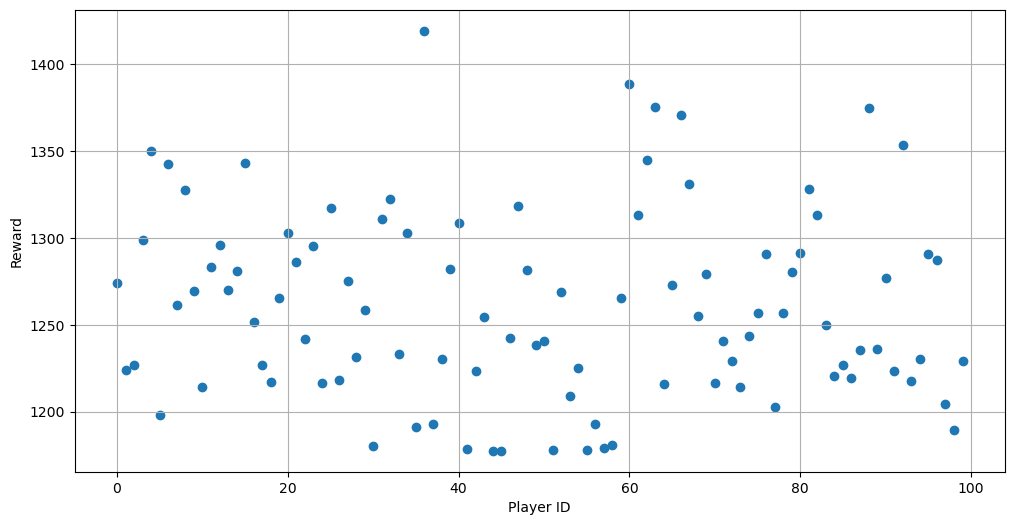

In [52]:
# Plotting the ratings
plt.figure(figsize=(12, 6))
plt.scatter(results_df['PlayerID'], results_df['pess_nn'])
plt.xlabel("Player ID")
plt.ylabel("Reward")
plt.grid(True)

plt.savefig('nn_pess.png')
plt.show()

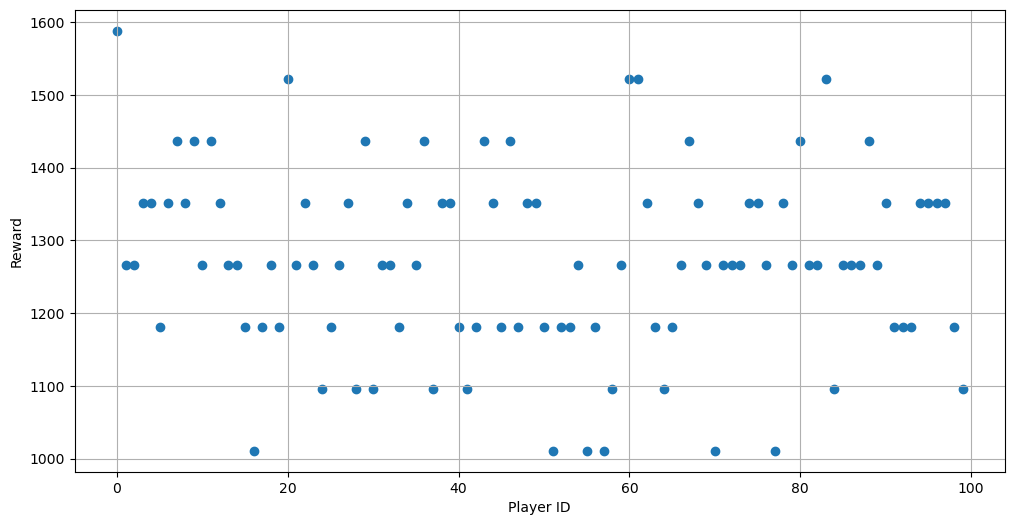

In [53]:
# Plotting the ratings
plt.figure(figsize=(12, 6))
plt.scatter(results_df['PlayerID'], results_df['Rating'] - results_df['RD'])
plt.xlabel("Player ID")
plt.ylabel("Reward")
plt.grid(True)

plt.savefig('glicko_pess.png')
plt.show()

In [129]:
from scipy.stats import norm, binom
p = norm.cdf(0, .1, 0.25)
opt_prob =  binom.cdf(m//2, m, p)
print(1-opt_prob**(n-1))

0.9998981663018016


2.426717965479739e-12
